### 0. Importing Libraries

In [2]:
# Your code here
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
from sklearn.metrics import root_mean_squared_error


def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Problem statement and data collection

In [4]:
df = pd.read_csv("../data/raw/medical_insurance_cost.csv")
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


----------------------------------------------------------------

### 2. Exploration and data cleaning 

#### 2.1 Understanding the features:
- age: Age of primary beneficiary (numeric)
- sex: Gender of the primary beneficiary (categorical)
- bmi: Body mass index (numeric)
- children: Number of children/dependents covered by health insurance (numeric)
- smoker: Is the person a smoker? (categorical)
- region: Beneficiary's residential area in the U.S.: northeast, southeast, southwest, northwest (categorical)
- charges: Health insurance premium (numerical)

In [8]:
print('Our dataframe contains {} rows and it has {} features.'.format(len(df), df.shape[1]))

Our dataframe contains 1338 rows and it has 7 features.


----------------------------------------------------------------

#### 2.2 Identifying Null Values and data types for each feature

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

##### Conclusions: 
- We don't have any nulls in the dataframe and we have categorical and numerical features. 

----------------------------------------------------------------

##### 2.3 Eliminating Irrelevant Information and dealing with null values

For this dataset, we will retain all features, as we believe each one plays an important role in predicting the target.

----------------------------------------------------------------

### 3. Univariate Analysis 

#### 3.1 Dividing our dataset into categorial and numerical. 

In [20]:
# Understanding how many type of features we have
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [21]:
# Dividing our dataframe by numerical and categorical features
num = ['int64', 'float64']
cat = ['O']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

----------------------------------------------------------------

#### 3.2 Categorical Variable Analysis 

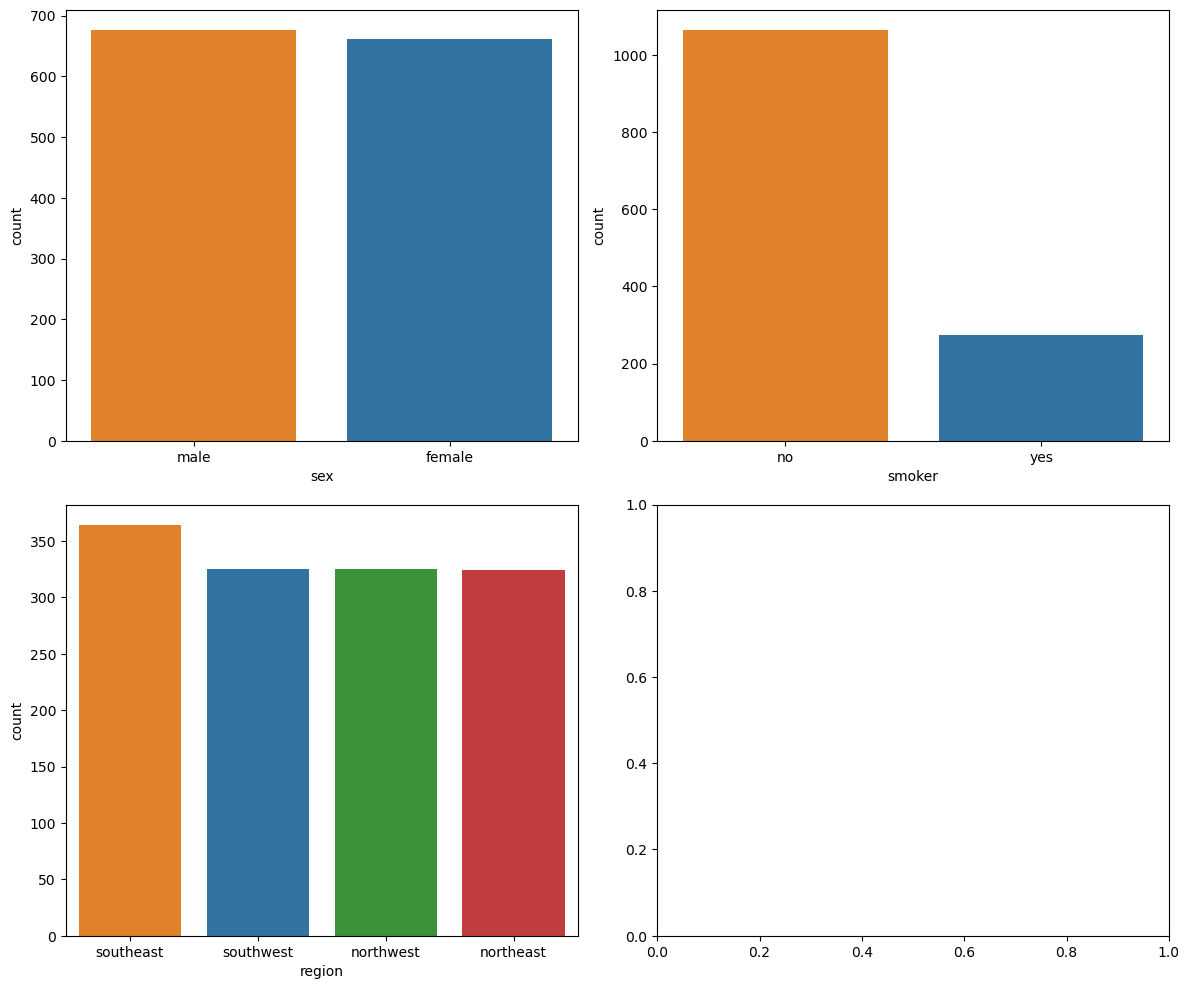

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
sns.countplot(ax= ax[0,0], data = df_cat, x = 'sex', order=df_cat['sex'].value_counts().index, hue='sex')
sns.countplot(ax = ax[0,1], data = df_cat, x = 'smoker', order=df_cat['smoker'].value_counts().index, hue='smoker')
sns.countplot(ax = ax[1,0], data = df_cat, x = 'region', order=df_cat['region'].value_counts().index, hue='region')

plt.tight_layout()
plt.show()

##### Conclusions

- **Gender Distribution:** The dataset shows a fairly balanced distribution between males and females. 
- **Smoking Status:** A significant majority of the individuals in the dataset are non-smokers, with a smaller proportion being smokers.
- **Regional Distribution:** The regional distribution indicates that the "southeast" region has the highest number of individuals, while the "southwest," "northwest," and "northeast" regions have a comparable number of participants. 

---------------------------------------------------------------

#### 3.3 Numerical Variable Analysis 

In [28]:
df_num.head(3)

,age,bmi,children,charges
0,19,27.90,0,16884.9240
1,18,33.77,1,1725.5523
2,28,33.00,3,4449.4620


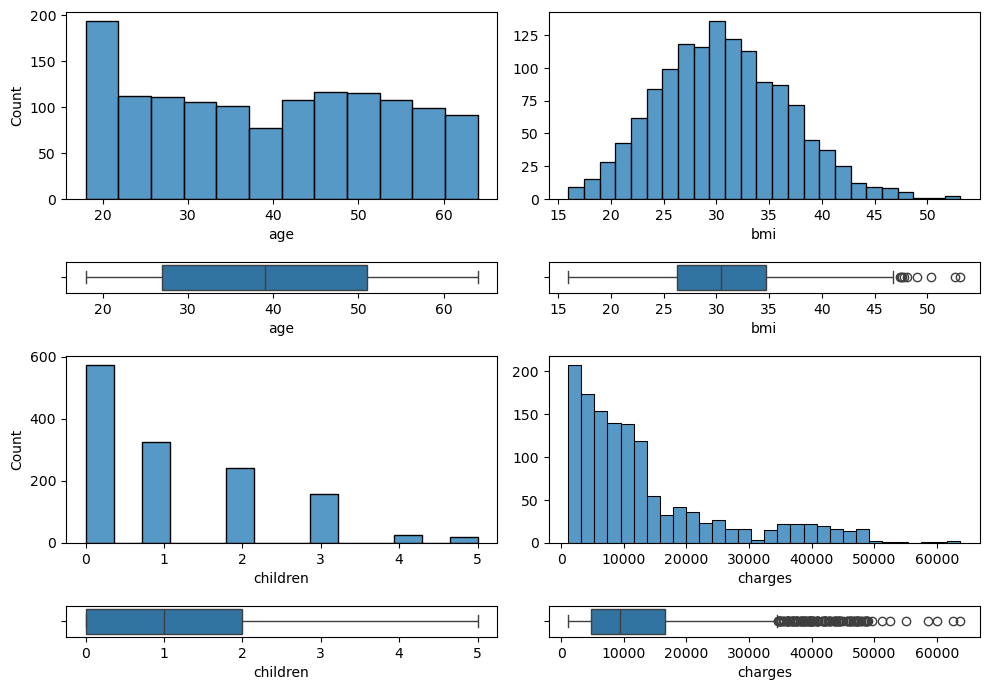

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(10, 7), gridspec_kw={'height_ratios': [6, 1, 6, 1]})

# Charts first row 
sns.histplot(ax = ax[0,0], data = df_num, x='age')
sns.boxplot(ax = ax[1,0], data = df_num, x='age')
sns.histplot(ax = ax[0,1], data = df_num, x='bmi').set(ylabel = None)
sns.boxplot(ax = ax[1,1], data = df_num, x='bmi')

# Charts second row 
sns.histplot(ax = ax[2,0], data = df_num, x='children')
sns.boxplot(ax = ax[3,0], data = df_num, x='children')
sns.histplot(ax = ax[2,1], data = df_num, x='charges').set(ylabel = None)
sns.boxplot(ax = ax[3,1], data = df_num, x='charges')

plt.tight_layout()
plt.show()

##### Conclusions
- **Age Distribution:** The age distribution is somewhat uniform, with a notable peak in the early 20s, suggesting a higher number of younger individuals. The boxplot indicates that the ages are fairly spread out with a median around the mid-30s. There are no significant outliers, implying a balanced dataset in terms of age representation.
- **BMI Distribution:** The BMI histogram shows a right-skewed distribution, with most values concentrated around 25–35, indicating that the majority of individuals fall within the overweight to moderately obese range. The boxplot highlights a few outliers above 40, indicating individuals with higher BMIs that may represent cases of severe obesity.
- **Children Count:** Most individuals in the dataset have no children, followed by those with one or two children. Families with three or more children are less common. The boxplot also confirms that higher numbers of children (e.g., four or five) are outliers in this dataset, suggesting that larger families are rare.
- **Charges Distribution:** The distribution of charges is heavily right-skewed, indicating that while most individuals have relatively low charges, there are a few who incur very high charges. The boxplot shows significant outliers, representing individuals with very high expenses, which could be due to exceptional cases like serious medical conditions or high insurance premiums.

----------------------------------------------------------------

### 4. Multivariate Analysis 

#### 4.1 Encoding Categorical Values and Saving JSON files

In [34]:
df_enc = df.copy()

In [35]:
# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.
for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))

In [36]:
# Replacing the values in our categorical features to our encoded values (numerical)
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

In [37]:
df_enc.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


----------------------------------------------------------------

#### 4.2 Numerical - categorical analysis (Correlation Analysis)

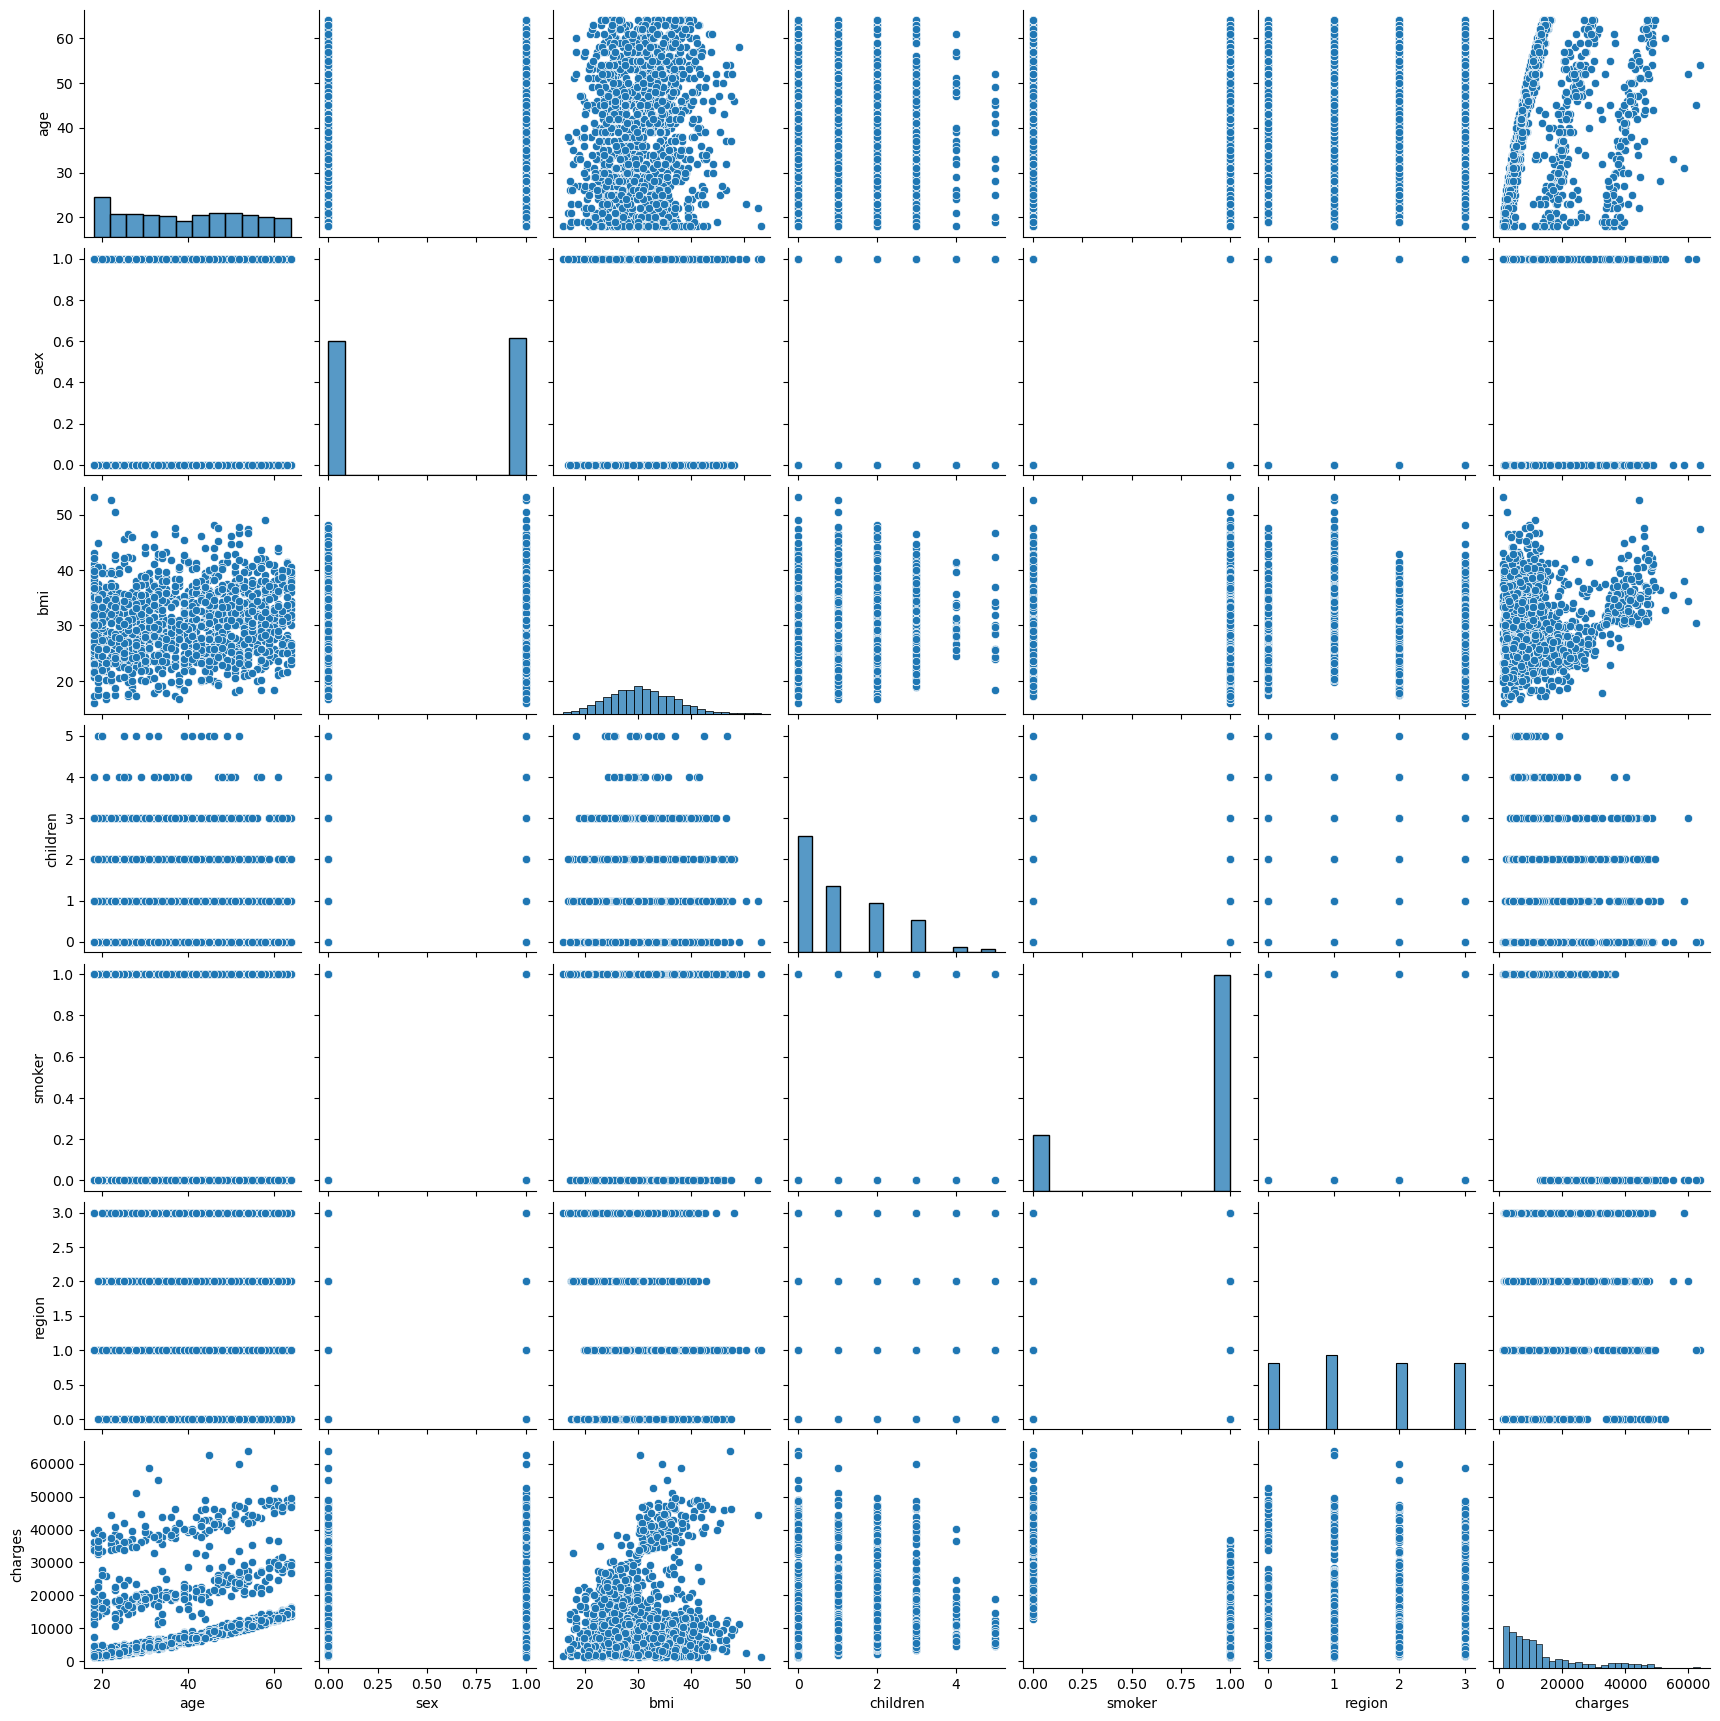

In [40]:
sns.pairplot(data=df_enc)
plt.show()

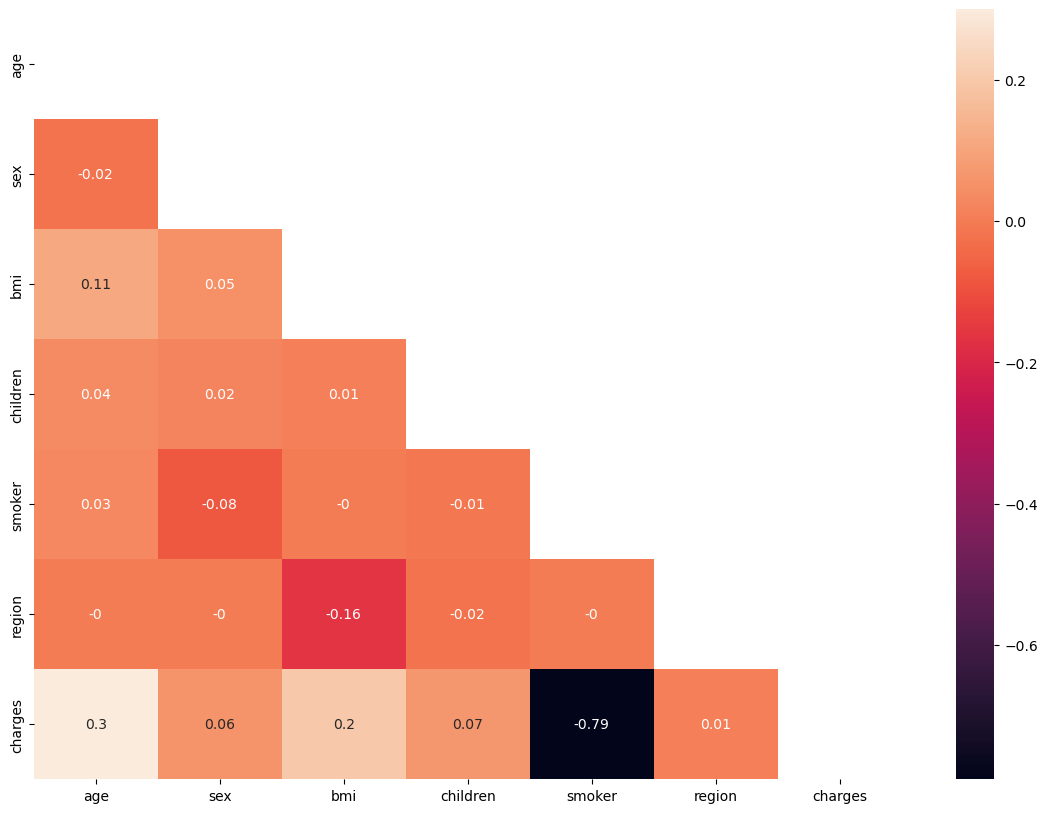

In [41]:
plt.figure(figsize=(14,10))
sns.heatmap(df_enc.corr().round(2), annot=True, mask=np.triu(df_enc.corr()))
plt.show()

###### Conclusions:
- **Smoker Status:** There is a strong negative correlation between being a smoker and medical charges, indicating that smokers incur significantly higher healthcare costs compared to non-smokers. This variable will be crucial for predicting charges.

- **Age:** A moderate positive correlation exists between age and medical charges, suggesting that older individuals generally have higher healthcare expenses.

- **BMI**: BMI shows a moderate positive correlation with charges, indicating that individuals with higher BMI levels tend to have higher medical expenses, likely due to associated health risks.

-------------------------------------------------------

### 5. Feature Engineering 
#### 5.1 New feature Inference

No new features will be created in this analysis, as the current set of variables is deemed sufficient for accurately capturing the relationships and insights needed for predicting medical charges.

-------------------------------------------------------

#### 5.2 Outlier Analysis

Perform an outlier analysis exclusively on continuous features; outliers in discrete features should be addressed separately without changing their data. 

In [49]:
df_enc.describe().round(2)

,age,sex,bmi,children,smoker,region,charges
count,1338.00,1338.00,1338.00,1338.00,1338.0,1338.00,1338.00
mean,39.21,0.51,30.66,1.09,0.8,1.48,13270.42
std,14.05,0.50,6.10,1.21,0.4,1.10,12110.01
min,18.00,0.00,15.96,0.00,0.0,0.00,1121.87
25%,27.00,0.00,26.30,0.00,1.0,1.00,4740.29
50%,39.00,1.00,30.40,1.00,1.0,1.00,9382.03
75%,51.00,1.00,34.69,2.00,1.0,2.00,16639.91
max,64.00,1.00,53.13,5.00,1.0,3.00,63770.43


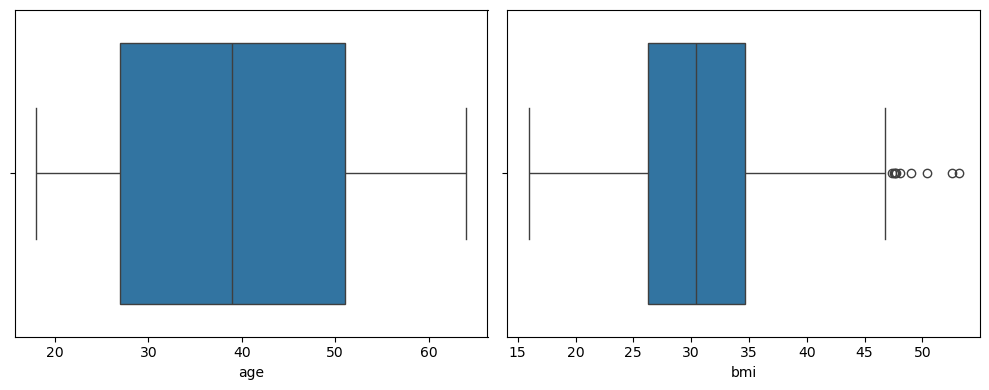

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

sns.boxplot(ax = ax[0], data = df_enc, x='age')
sns.boxplot(ax = ax[1], data = df_enc, x='bmi')

plt.tight_layout()
plt.show()

We will calculate the outlier limits for ```bmi```. This data will be used to create a new data frame without outliers (```df_enc_no```), which we will use to train our model and compare performance to determine the best approach.

In [52]:
# Creating a copy of our df to remove outliers 
df_enc_no = df_enc.copy()

In [53]:
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [54]:
f_outliers_no_neg = ['bmi']

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

--------------------------------------------------------

#### 5.3 Missing Values

In [57]:
df_enc.isna().sum()[df_enc.isna().sum()>0]

Series([], dtype: int64)

--------------------------------------------------------

#### 5.4 Split train/test of both Data Frames

In [60]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

Now, we split our data into train and test sets using the function ```split``` created earlier. This will be for all necessary data frames created earlier (original, normalized, and min-max scaled for both, with outliers and without outliers).

In [62]:
# Split original dataframe 
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('charges', df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split('charges', df_enc_no)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

--------------------------------------------------------

#### 5.5 Normalization

In [65]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'../data/processed/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [66]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

--------------------------------------------------------

#### 5.5 Min-Max Scaling

In [69]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'../data/processed/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [70]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

--------------------------------------------------------

### 6. Feature Selection 

In [73]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'../data/processed/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel  

In [74]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 'all', 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 'all', 'without_outliers')

C:\Users\noehu\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\noehu\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


#### 6.1 Applying the columns filter (kselection) to the normalized and minmax scaled data frames

In [76]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

#### 6.2 Saving the CSV files 

In [78]:
dfs_train = {
    'X_train_with_outliers_sel': X_train_with_outliers_sel,
    'X_train_without_outliers_sel': X_train_without_outliers_sel,
    'X_train_with_outliers_norm_sel': X_train_with_outliers_norm_sel,
    'X_train_without_outliers_norm_sel': X_train_without_outliers_norm_sel,
    'X_train_with_outliers_minmax_sel': X_train_with_outliers_minmax_sel,
    'X_train_without_outliers_minmax_sel': X_train_without_outliers_minmax_sel 
}

dfs_test = {
    'X_test_with_outliers_sel': X_test_with_outliers_sel,
    'X_test_without_outliers_sel': X_test_without_outliers_sel,
    'X_test_with_outliers_norm_sel': X_test_with_outliers_norm_sel,
    'X_test_without_outliers_norm_sel': X_test_without_outliers_norm_sel,
    'X_test_with_outliers_minmax_sel': X_test_with_outliers_minmax_sel,
    'X_test_without_outliers_minmax_sel': X_test_without_outliers_minmax_sel    
}

for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)
    

--------------------------------------------------------

### Machine Learning
#### 1.0 Decision Making: Which is the best dataset? -> Linear Regression

In [81]:
train, test = [], []

for name, df in dfs_train.items():
    train.append(df)
for name, df in dfs_test.items():
    test.append(df)

In [85]:
results = []

for index in range(len(train)):
    model = LinearRegression()
    train_df = train[index]
    model.fit(train_df, y_train)
    y_test_pred = model.predict(test[index])

    results.append(
        {
            'index': index,
            'df_train': list(dfs_train.keys())[index],
            'Coef': model.coef_,
            'MAE': mean_absolute_error(y_test, y_test_pred).round(2),
            'RMSE': root_mean_squared_error(y_test, y_test_pred),
            "R2_score": r2_score(y_test, y_test_pred)            
        }
    )

results = sorted(results, key=lambda x: x['RMSE'])
best_ind = results[0]['index']
best_df_train = results[0]['df_train']
results

[{'index': 2,
  'df_train': 'X_train_with_outliers_norm_sel',
  'Coef': array([ 3610.72712548,   -41.02826769,  2025.57911637,   555.74486739,
         -9389.18086358,   403.62569518]),
  'MAE': 4009.55,
  'RMSE': 5531.784303349205,
  'R2_score': 0.7998591998802312},
 {'index': 4,
  'df_train': 'X_train_with_outliers_minmax_sel',
  'Coef': array([ 11773.09948841,    -82.0616962 ,  12511.60734608,   2276.08947352,
         -23472.95215894,   1110.79625216]),
  'MAE': 4009.55,
  'RMSE': 5531.784303349206,
  'R2_score': 0.7998591998802311},
 {'index': 0,
  'df_train': 'X_train_with_outliers_sel',
  'Coef': array([   255.9369454 ,    -82.0616962 ,    336.60498644,    455.2178947 ,
         -23472.95215894,    370.26541739]),
  'MAE': 4009.55,
  'RMSE': 5531.784303349207,
  'R2_score': 0.799859199880231},
 {'index': 3,
  'df_train': 'X_train_without_outliers_norm_sel',
  'Coef': array([ 3603.55742615,   -37.67993626,  2031.61591228,   553.48266956,
         -9390.40497179,   404.67516031]),

In [87]:
print(f'Our best dataframe is {best_df_train}, with an RMSE of {results[index].get("MSE")} and a R2_score of {results[index].get("R2_score")}')

Our best dataframe is X_train_with_outliers_norm_sel, with an MSE of None and a R2_score of 0.7997632598249401


In [ ]:
# Test to find the error

In [91]:
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('charges', df_enc)

In [137]:
model = LinearRegression()
model.fit(X_train_with_outliers, y_train)
y_pred = model.predict(X_test_with_outliers)
            
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ', root_mean_squared_error(y_test, y_test_pred))
print('r2_score: ', r2_score(y_test, y_pred))

MAE:  4009.551705250051
RMSE:  5533.110010314062
r2_score:  0.799859199880231


In [131]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 4, 'with_outliers')

C:\Users\noehu\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [133]:
model = LinearRegression()
model.fit(X_train_with_outliers_sel, y_train)
y_pred = model.predict(X_test_with_outliers_sel)
            
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ', root_mean_squared_error(y_test, y_test_pred))
print('r2_score: ', r2_score(y_test, y_pred))

MAE:  5133.95393347102
RMSE:  5533.110010314062
r2_score:  0.7158898466320489
